In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import seaborn as sns
import statsmodels.api as sm
import matplotlib.patches as mpatches
import geopandas as gpd

plt.rcParams['axes.axisbelow'] = True

In [2]:
# Get the absolute path of the parent directory
# parent_dir = str(Path(__file__).resolve().parent.parent)

parent_dir = str(Path().cwd().parent)

# Add the parent directory to sys.path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Now you can import the module as if it was in the same directory
import utils.aadt_predictor as ap

### Load data

In [3]:
HPMS_DIR = Path('../../data/processed_data/HPMS')
RANDOM_STATE = 42
RESPONSE_VARS = ['AADT_MDV', 'AADT_HDV']
RF_PREDICTOR_VARS = ["STATEFP", "COUNTYFP", "F_SYSTEM", "THROUGH_LANES", "AADT"]

predictor = ap.AADTPredictor(HPMS_DIR / 'hpms_aadt_subset.csv', None, random_state = RANDOM_STATE)

Loading data from ..\..\data\processed_data\HPMS\hpms_aadt_subset.csv


c:\Users\achawla1\Desktop\work\NearRoadExposure\scripts\utils\aadt_predictor.py:37: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data_full = pd.read_csv(self.data_path)


Full Data loaded successfully: 6598607 rows and 17 columns.
Pre-processing data...
ERROR: The data could not be subsetted. [None]
ERROR: The data could not be loaded. 'NoneType' object has no attribute 'shape'


In [4]:
county_gdf = gpd.read_file('../../data/raw_data/census/counties/tl_2020_us_county/tl_2020_us_county.shp')

In [5]:
def plot_collinearity(predictor, out):

    df = predictor.data_full

    df['log_AADT'] = np.log(df['AADT'] + 1)
    df['log_AADT_MDV'] = np.log(df['AADT_MDV'] + 1)
    df['log_AADT_HDV'] = np.log(df['AADT_HDV'] + 1)

    plt.scatter(x=df['log_AADT_HDV'], y=df['log_AADT_MDV'], facecolors='none', edgecolors='blue', alpha=0.3)
    plt.xlabel('log(HDV AADT)')
    plt.ylabel('log(MDV AADT)')
    plt.suptitle('log HDV and MDV AADT')
    plt.grid(True, zorder=1, color='black', alpha=0.5)
    plt.tight_layout()

    plt.savefig(out, dpi=300)

In [6]:
def train_test_random_forest(predictor, response_var, optim_params, test_size=0.2):
    
    predictor.response_var = response_var
    predictor.subset_train_data()

    predictor.split_data(RF_PREDICTOR_VARS, state_fips= None, test_size=test_size)

    predictor.initialize_model('Random Forest', n_jobs = -1, random_state = RANDOM_STATE, **optim_params)

    predictor.fit_model()

    return predictor

In [7]:
def accuracy_measurements(predictor):

    r2, mae, mse = predictor.test_model()

    return {'r2': r2, 'mae': mae, 'rmse': np.sqrt(mse)}

In [8]:
def get_residuals_lowess(predictor, lowess_frac = 0.3):

    predictor.y_pred = predictor.model.predict(predictor.X_test)
    predictor.residuals = predictor.y_test - predictor.y_pred

    if lowess_frac is not None:
        lowess = sm.nonparametric.lowess
        predictor.z = lowess(predictor.residuals, predictor.y_test, frac=lowess_frac)

    return predictor

In [9]:
def train_test_random_forest(predictor, response_var, optim_params, test_size=0.2):
    
    predictor.response_var = response_var
    predictor.subset_train_data()

    predictor.split_data(RF_PREDICTOR_VARS, state_fips= None, test_size=test_size)

    predictor.initialize_model('Random Forest', n_jobs = -1, random_state = RANDOM_STATE, **optim_params)

    predictor.fit_model()

    return predictor

In [10]:
def plot_residuals(predictor, traffic_class, model_class, out):
    
    plt.figure(figsize=(8, 3))

    plt.scatter(predictor.y_test, predictor.residuals, facecolors='none', edgecolors='blue', alpha=0.3)
    plt.plot(predictor.z[:,0], predictor.z[:,1], color='red', linewidth=2, label='Lowess Fit')
    
    plt.xlabel(f'Observed AADT {traffic_class}')
    plt.ylabel('Residuals')
    plt.suptitle(f'Residuals vs Observed AADT {traffic_class} - {model_class}')

    plt.legend()
    plt.grid(True, zorder=1, color='black', alpha=0.5)
    plt.tight_layout()

    plt.savefig(out, dpi=300)

In [11]:
def plot_categorical_boxplots(predictor, traffic_class, model_class, out):

    def format_bins(bin_range): 
        return f"{int(bin_range.left/1000)}-{int(bin_range.right/1000)}"
    
    # bin AADT to desired resolution
    aadt_bins = pd.cut(predictor.X_test['AADT'], bins=4)
    predictor.X_test['AADT_binned'] = aadt_bins

    # get through lanes as int
    predictor.X_test['THROUGH_LANES'] = predictor.X_test['THROUGH_LANES'].astype(int)
 
    fig, ax = plt.subplots(1, 3, figsize=(12, 6), gridspec_kw={'width_ratios': [3.2, 2, 2]}, sharey=True)

    colors = ['red', 'blue'] # ['observed', 'predicted]
    x_label_dict = {'THROUGH_LANES': 'Through Lanes', 'F_SYSTEM': 'F System', 'AADT_binned': 'Total AADT (1e3)'}

    for i, var in enumerate(['THROUGH_LANES', 'F_SYSTEM', 'AADT_binned']):
        categories = sorted(predictor.X_test[var].unique())
        for j, category in enumerate(categories): 
            observed = predictor.y_test[predictor.X_test[var] == category] 
            predicted = predictor.y_pred[predictor.X_test[var] == category] 
            data = [observed, predicted] 
            positions = [j*2, j*2+1] 
            bplot = ax[i].boxplot(data, positions=positions, notch=False, patch_artist=True, widths=0.6, showfliers=False)
            for patch, color in zip(bplot['boxes'], colors):
                patch.set_facecolor(color)
            ax[i].set_xticks([j*2+0.5 for j in range(len(categories))])
            if var=='AADT_binned':
                ax[i].set_xticklabels([format_bins(category) for category in categories]) 
            else:
                ax[i].set_xticklabels(categories) 
            
            ax[i].set_xlabel(x_label_dict[var])
        
    ax[0].set_ylabel(f'AADT {traffic_class}')
    plt.suptitle(f'AADT {traffic_class} Observed vs Predicted for each Predictor Variable - {model_class}')

    blue_patch = mpatches.Patch(color='red', label='Observed')
    red_patch = mpatches.Patch(color='blue', label='Predicted')
    fig.legend(handles=[blue_patch, red_patch], loc='upper right')

    plt.tight_layout() 

    plt.savefig(out, dpi=300)
    plt.show()
    

In [12]:
def plot_error_map():
    pass

### MDV and HDV Collinearity

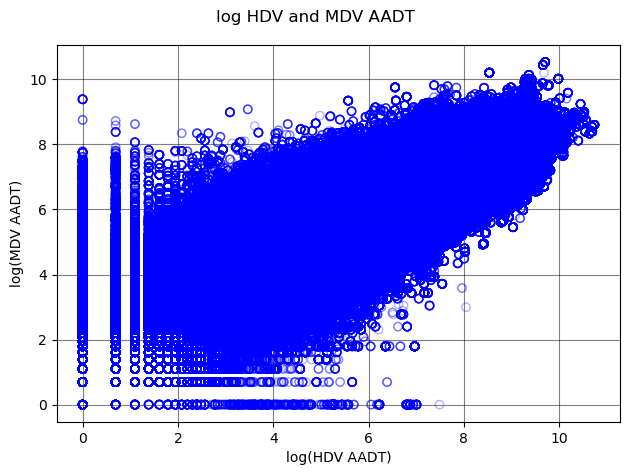

In [13]:
plot_collinearity(predictor, '../../figs/hdv_mdv_scatter.png')

### Train-Test

#### MDV - RFR

In [14]:
response_var = RESPONSE_VARS[0]
mdv_optim_params = {'n_estimators': 98, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'max_features': None}

mdv_predictor = train_test_random_forest(predictor, response_var, mdv_optim_params)

Training Data subsetted successfully with AADT_MDV: 4766630 rows and 20 columns.
Training and testing data split with test size 0.2 on State None and not stratified ...
Random Forest model initialized with- {'n_jobs': -1, 'random_state': 42, 'n_estimators': 98, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'max_features': None}
Model trained successfully


In [15]:
mdv_scores = accuracy_measurements(mdv_predictor)
mdv_scores

{'r2': 0.9940713240112768,
 'mae': 12.952105568553227,
 'rmse': 87.03613195406469}

In [16]:
# get residuals and lowess
mdv_predictor = get_residuals_lowess(mdv_predictor, lowess_frac = None)

AttributeError: 'AADTPredictor' object has no attribute 'z'

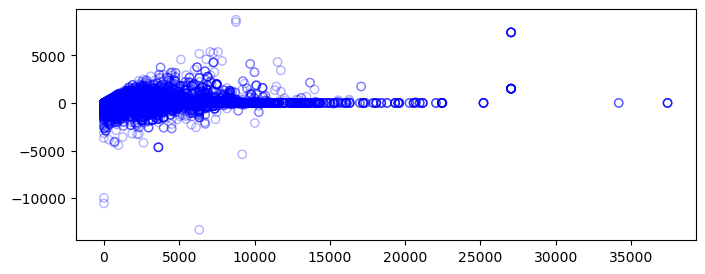

In [17]:
plot_residuals(mdv_predictor, 'MDV', 'Random Forest', '../../figs/residual_lowess_mdv.png')

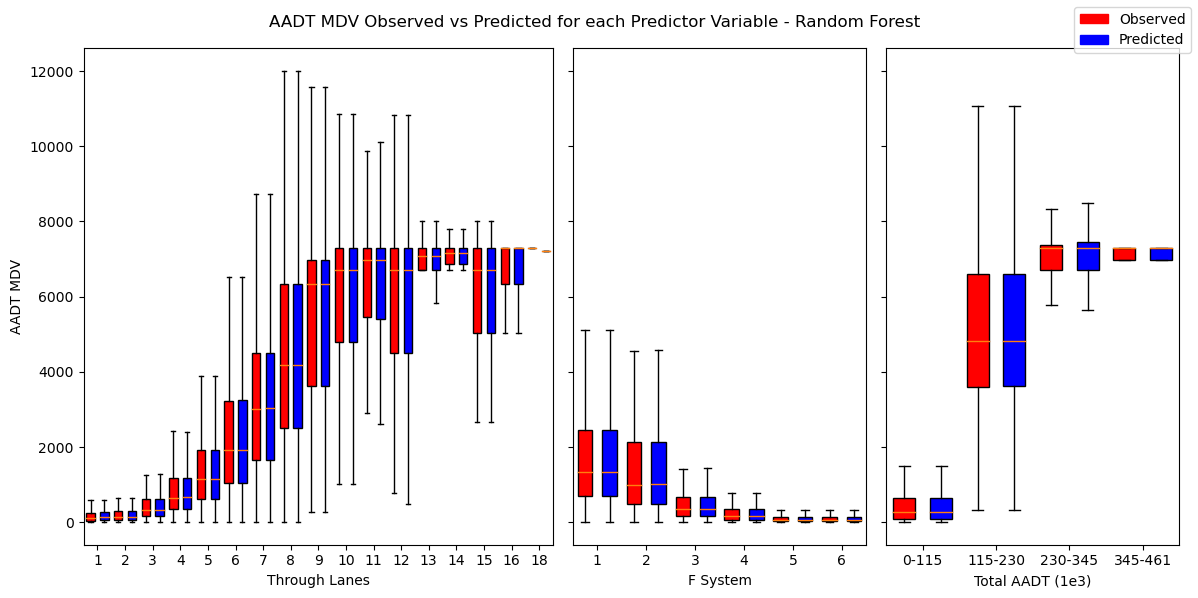

In [18]:
plot_categorical_boxplots(mdv_predictor, 'MDV', 'Random Forest', '../../figs/boxplot_mdv.png')

In [19]:
import copy

cp_predictor = copy.deepcopy(mdv_predictor)

In [20]:
cp_predictor.X_test['y_pred'] = cp_predictor.y_pred
cp_predictor.X_test['y_test'] = cp_predictor.y_test

cp_predictor.X_test['mape'] = np.abs(cp_predictor.X_test['y_test'] - cp_predictor.X_test['y_pred']) / cp_predictor.X_test['y_test']

# replace nans and infs with 0
cp_predictor.X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# calculate GEOID
cp_predictor.X_test['GEOID'] = cp_predictor.X_test['STATEFP'].astype(str) + cp_predictor.X_test['COUNTYFP'].astype(str)

In [21]:
# join with county gdf at GEOID
county_gdf_merge = county_gdf.merge(cp_predictor.X_test, on='GEOID', how='left')

county_gdf_merge = gpd.GeoDataFrame(county_gdf_merge, geometry='geometry')

In [24]:
gdf_plot = county_gdf_merge[['STATEFP_x', 'COUNTYFP_x', 'mape', 'geometry']]

In [ ]:
county_gdf_merge.plot()

In [26]:
gdf_plot.plot(column='mape', legend=True)